In [5]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class ICUEnv(gym.Env):
    def __init__(self):
        super(ICUEnv, self).__init__()

        # State: [Heart Rate, Oxygen Level, Blood Pressure]
        self.observation_space = spaces.Box(low=np.array([60, 80, 90]), 
                                            high=np.array([180, 100, 160]), dtype=np.float32)

        # Actions: [Decrease Medication, Maintain, Increase Medication]
        self.action_space = spaces.Discrete(3)

        self.state = np.array([100, 95, 120])  # Initial Patient Condition
        self.done = False

    def step(self, action):
        heart_rate, oxygen_level, blood_pressure = self.state

        # Action effects
        if action == 0:  # Decrease medication
            heart_rate -= 5
            blood_pressure -= 3
        elif action == 2:  # Increase medication
            heart_rate += 5
            blood_pressure += 3

        # Keep values within range
        heart_rate = np.clip(heart_rate, 60, 180)
        oxygen_level = np.clip(oxygen_level, 80, 100)
        blood_pressure = np.clip(blood_pressure, 90, 160)

        # Reward Function: Keep vitals stable (closer to normal)
        reward = -abs(heart_rate - 100) - abs(oxygen_level - 95) - abs(blood_pressure - 120)

        self.state = np.array([heart_rate, oxygen_level, blood_pressure])

        terminated = False
        truncated = False
        return self.state, reward, terminated, truncated, {}


    def reset(self, seed=None):
        self.state = np.array([100, 95, 120])
        self.done = False
        return self.state, {}

    def render(self):
        print(f"Heart Rate: {self.state[0]}, Oxygen: {self.state[1]}, BP: {self.state[2]}")


In [6]:
from stable_baselines3 import DQN

env = ICUEnv()
model_dqn = DQN("MlpPolicy", env, verbose=1)
model_dqn.learn(total_timesteps=50000)
model_dqn.save("dqn_icu")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [8]:
class ICUEnvContinuous(ICUEnv):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

    def step(self, action):
        heart_rate, oxygen_level, blood_pressure = self.state

        # Convert continuous action [-1,1] to medication change [-5,5]
        medication_change = int(action[0] * 5)
        heart_rate += medication_change
        blood_pressure += medication_change

        # Clip values
        heart_rate = np.clip(heart_rate, 60, 180)
        blood_pressure = np.clip(blood_pressure, 90, 160)

        # Reward function
        reward = -abs(heart_rate - 100) - abs(oxygen_level - 95) - abs(blood_pressure - 120)

        self.state = np.array([heart_rate, oxygen_level, blood_pressure])

        terminated = False
        truncated = False

        return self.state, reward, terminated, truncated, {}

env_continuous = ICUEnvContinuous()

from stable_baselines3 import SAC
model_sac = SAC("MlpPolicy", env_continuous, verbose=1)
model_sac.learn(total_timesteps=50000)
model_sac.save("sac_icu")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


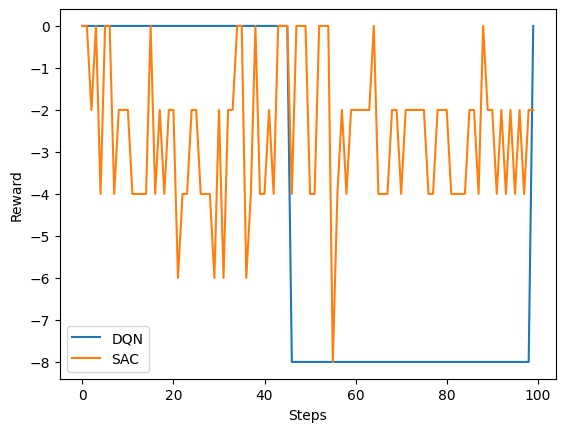

In [10]:
import matplotlib.pyplot as plt

# Load trained models
model_dqn = DQN.load("dqn_icu")
model_sac = SAC.load("sac_icu")

# Test models on ICU environment
def evaluate_model(model, env, steps=100):
    states, rewards = [], []
    obs, _ = env.reset()
    for _ in range(steps):
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        done=terminated or terminated
        states.append(obs)
        rewards.append(reward)
    return states, rewards

states_dqn, rewards_dqn = evaluate_model(model_dqn, env)
states_sac, rewards_sac = evaluate_model(model_sac, env_continuous)

# Plot reward comparison
plt.plot(rewards_dqn, label="DQN")
plt.plot(rewards_sac, label="SAC")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend()
plt.show()

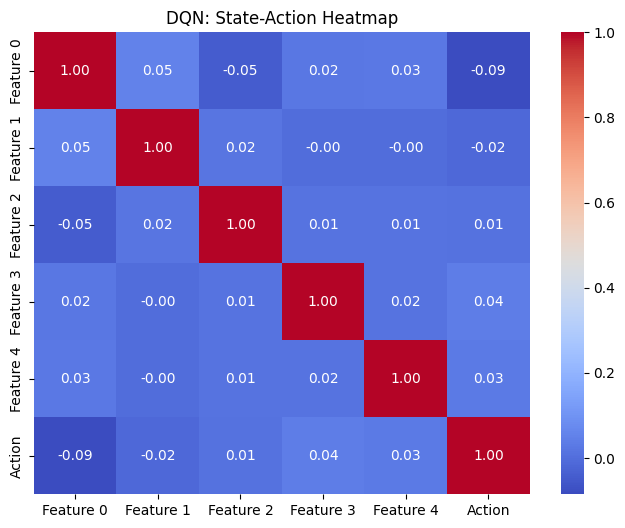

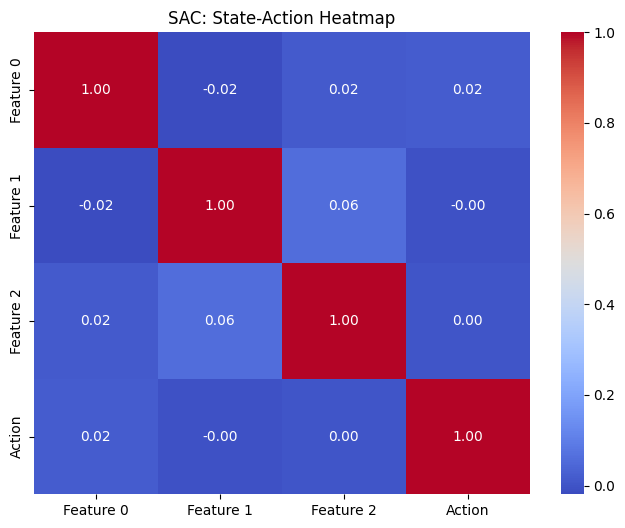

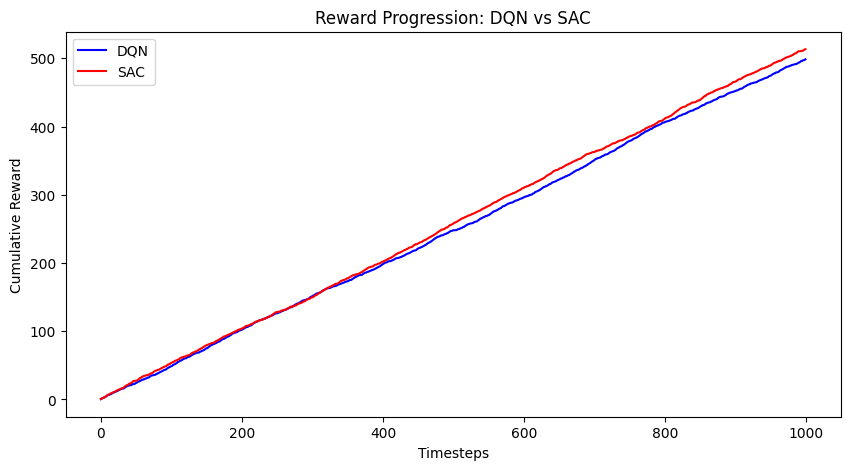

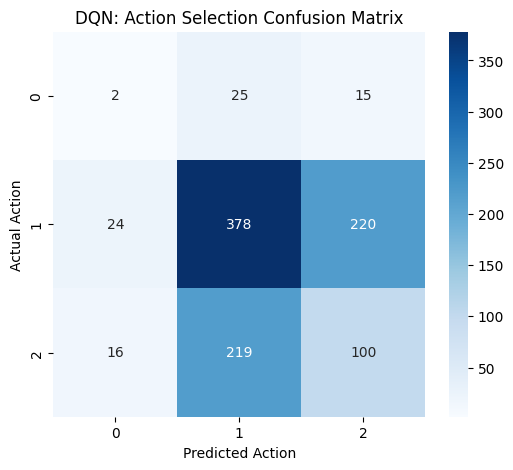

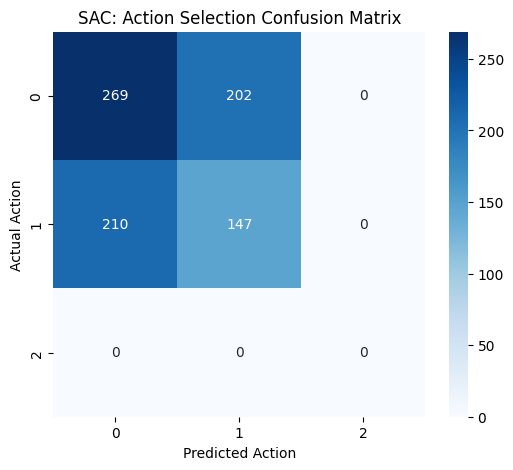

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gym
from stable_baselines3 import DQN, SAC
from sklearn.metrics import confusion_matrix
import pandas as pd

# Load the saved models
model_dqn = DQN.load("dqn_icu")
model_sac = SAC.load("sac_icu")

# Custom ICU Environment (Now supports different observation shapes)
class ICUEnv(gym.Env):
    def __init__(self, obs_shape=5):  # Default to (5,)
        super(ICUEnv, self).__init__()
        self.obs_shape = obs_shape
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.obs_shape,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(3)

    def reset(self):
        return np.random.rand(self.obs_shape)

    def step(self, action):
        next_state = np.random.rand(self.obs_shape)
        reward = np.random.rand()
        done = np.random.choice([True, False], p=[0.1, 0.9])
        return next_state, reward, done, {}

# Initialize Environments for Each Model
env_dqn = ICUEnv(obs_shape=5)  # 5-dimensional for DQN
env_sac = ICUEnv(obs_shape=3)  # 3-dimensional for SAC

# Function to Evaluate Models
def evaluate_model(model, env, steps=1000):
    obs = env.reset()
    states, rewards, actions = [], [], []
    
    for _ in range(steps):
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        states.append(obs)
        rewards.append(reward)
        actions.append(action)
        if done:
            obs = env.reset()
    
    return np.array(states), np.array(rewards), np.array(actions)

# Evaluate Models with Correct Environments
states_dqn, rewards_dqn, actions_dqn = evaluate_model(model_dqn, env_dqn)
states_sac, rewards_sac, actions_sac = evaluate_model(model_sac, env_sac)

# Heatmap of State-Action Pairs
def plot_heatmap(states, actions, title):
    df = pd.DataFrame(states, columns=[f"Feature {i}" for i in range(states.shape[1])])
    df['Action'] = actions
    heatmap_data = df.corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(title)
    plt.show()

plot_heatmap(states_dqn, actions_dqn, "DQN: State-Action Heatmap")
plot_heatmap(states_sac, actions_sac, "SAC: State-Action Heatmap")

# Reward Progression Over Time
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(rewards_dqn), label="DQN", color='blue')
plt.plot(np.cumsum(rewards_sac), label="SAC", color='red')
plt.xlabel("Timesteps")
plt.ylabel("Cumulative Reward")
plt.title("Reward Progression: DQN vs SAC")
plt.legend()
plt.show()

#  Confusion Matrix for Action Selection
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel("Predicted Action")
    plt.ylabel("Actual Action")
    plt.title(title)
    plt.show()

# Shifted action labels to align predicted and actual actions correctly
# Convert SAC actions to discrete values
actions_sac_discrete = np.round(actions_sac).astype(int)  # Ensure actions are integers

# Plot Confusion Matrices
plot_confusion_matrix(actions_dqn[:-1], actions_dqn[1:], "DQN: Action Selection Confusion Matrix")
plot_confusion_matrix(actions_sac_discrete[:-1], actions_sac_discrete[1:], "SAC: Action Selection Confusion Matrix")
